In [ ]:
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
data = yf.download('MSFT', start='2000-01-01', end='2023-12-31')

data = data[['Close']]

scaler = MinMaxScaler()
data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


[*********************100%%**********************]  1 of 1 completed
<ipython-input-2-84cd539b8263>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Close'] = scaler.fit_transform(data['Close'].values.reshape(-1, 1))


In [ ]:
SEQUENCE_SIZE = 11

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

X, y = to_sequences(SEQUENCE_SIZE, data['Close'].values)

In [ ]:
split_index = int(len(X) * 0.8)
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]
X_train = X_train.reshape(-1, SEQUENCE_SIZE, 1)
X_test = X_test.reshape(-1, SEQUENCE_SIZE, 1)

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

batch_size = 64
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1):
        super(VanillaRNN, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = nn.RNN(input_size, hidden_layer_size, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(1, input_seq.size(0), self.hidden_layer_size).to(input_seq.device)
        rnn_out, _ = self.rnn(input_seq, h0)
        predictions = self.linear(rnn_out[:, -1])
        return predictions

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
model = VanillaRNN(input_size=1).to('cuda')
model.apply(init_weights)
loss_function = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
epochs = 200
for epoch in range(epochs):
    model.train()
    for seq, labels in train_loader:
        seq, labels = seq.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        y_pred = model(seq)
        labels = labels.reshape((y_pred.shape[0], 1))
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch: {epoch:3} Loss: {single_loss.item():10.8f}')

Epoch:   0 Loss: 0.00071567
Epoch:  10 Loss: 0.00221091
Epoch:  20 Loss: 0.00230961
Epoch:  30 Loss: 0.00213057
Epoch:  40 Loss: 0.00193550
Epoch:  50 Loss: 0.00163822
Epoch:  60 Loss: 0.00128616
Epoch:  70 Loss: 0.00094278
Epoch:  80 Loss: 0.00064771
Epoch:  90 Loss: 0.00041312
Epoch: 100 Loss: 0.00023545
Epoch: 110 Loss: 0.00011296
Epoch: 120 Loss: 0.00004652
Epoch: 130 Loss: 0.00002070
Epoch: 140 Loss: 0.00001263
Epoch: 150 Loss: 0.00001013
Epoch: 160 Loss: 0.00000927
Epoch: 170 Loss: 0.00000894
Epoch: 180 Loss: 0.00000881
Epoch: 190 Loss: 0.00000875


In [ ]:
torch.save(model.state_dict(), 'vanilla_rnn_model.pth')

In [ ]:
model.eval()
y_pred = []
with torch.no_grad():
    for seq, _ in test_loader:
        seq = seq.to('cuda')
        y_pred.append(model(seq).item())

In [ ]:
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inverse = scaler.inverse_transform(np.array(y_pred).reshape(-1, 1))


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
print(f'RMSE: {rmse}')
r_squared = r2_score(y_test_inverse, y_pred_inverse)
print(f'R-squared: {r_squared}')

RMSE: 5.910679136441778
R-squared: 0.992592764864102


In [ ]:
time_test = data.index[split_index + SEQUENCE_SIZE:]
results = pd.DataFrame({'Date': time_test, 'Close': y_pred_inverse.flatten()})
results.to_csv('submission.csv', index=False)

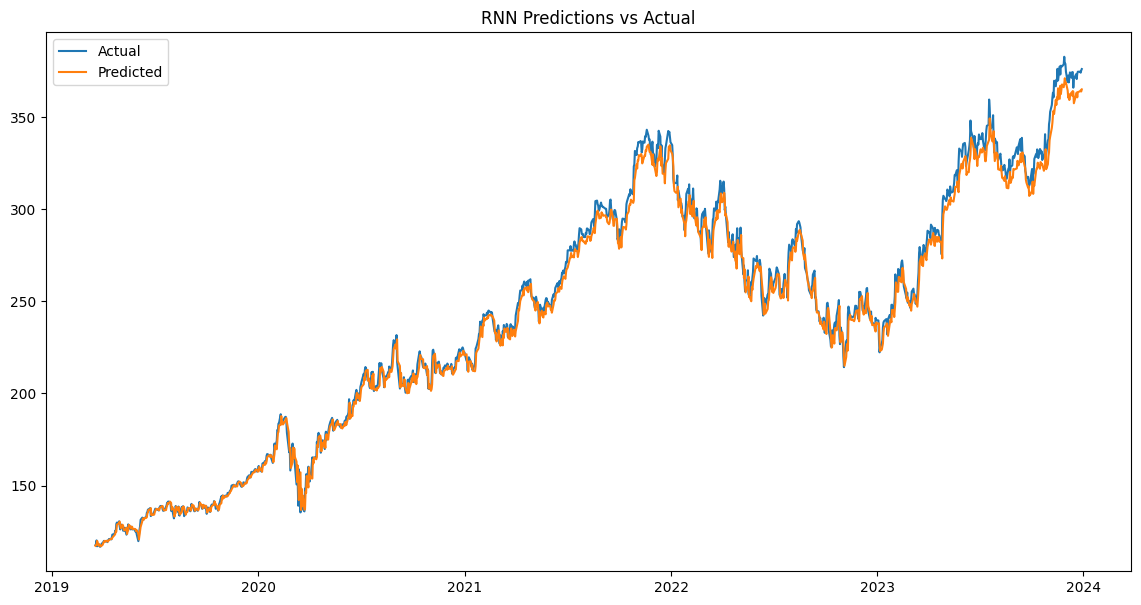

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(time_test, y_test_inverse, label='Actual')
plt.plot(time_test, y_pred_inverse, label='Predicted')
plt.legend()
plt.title('RNN Predictions vs Actual')
plt.show()

In [ ]:
new_data = yf.download('AAPL', start='2000-01-01', end='2023-12-31')
new_data = new_data[['Close']]
new_data['Close'] = scaler.transform(new_data['Close'].values.reshape(-1, 1))

X_new, y_new = to_sequences(SEQUENCE_SIZE, new_data['Close'].values)
X_new = X_new.reshape(-1, SEQUENCE_SIZE, 1)

test_dataset_new = TimeSeriesDataset(X_new, y_new)
test_loader_new = DataLoader(test_dataset_new, batch_size=1, shuffle=False)

model_new = VanillaRNN(input_size=1).to('cuda')
model_new.load_state_dict(torch.load('vanilla_rnn_model.pth'))

model_new.eval()
y_pred_new = []
with torch.no_grad():
    for seq, _ in test_loader_new:
        seq = seq.to('cuda')
        y_pred_new.append(model_new(seq).item())

y_test_new_inverse = scaler.inverse_transform(y_new.reshape(-1, 1))
y_pred_new_inverse = scaler.inverse_transform(np.array(y_pred_new).reshape(-1, 1))

[*********************100%%**********************]  1 of 1 completed
<ipython-input-16-648d568e8e33>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Close'] = scaler.transform(new_data['Close'].values.reshape(-1, 1))


In [ ]:
rmse_new = np.sqrt(mean_squared_error(y_test_new_inverse, y_pred_new_inverse))
print(f'New RMSE: {rmse_new}')
r_squared_new = r2_score(y_test_new_inverse, y_pred_new_inverse)
print(f'New R-squared: {r_squared_new}')

New RMSE: 1.1364199855400263
New R-squared: 0.9995048645922584


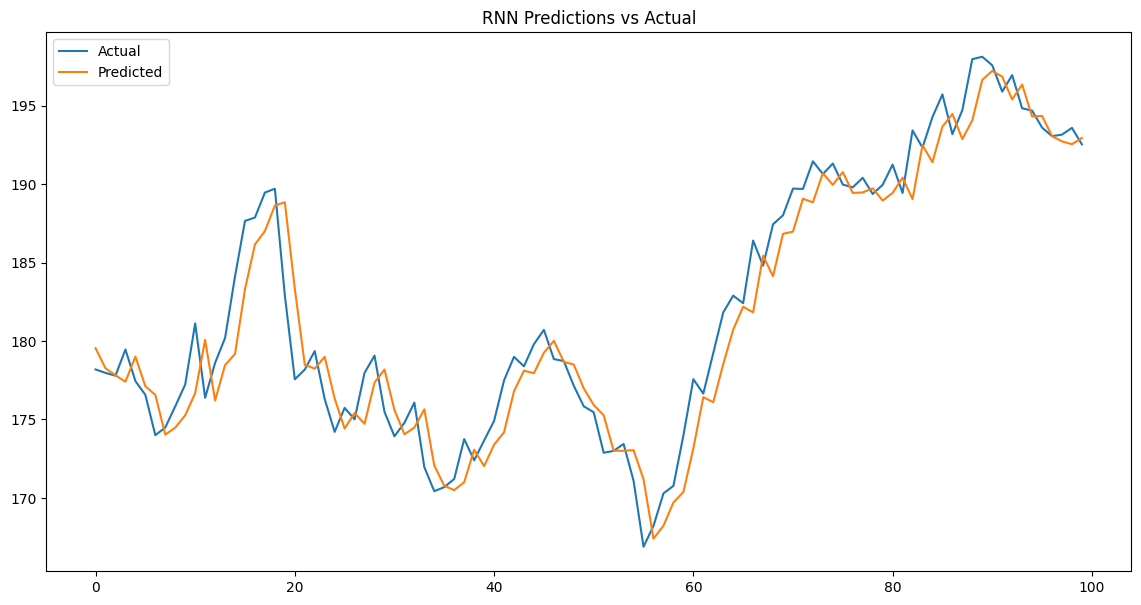

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_new_inverse[-100:], label='Actual')
plt.plot(y_pred_new_inverse[-100:], label='Predicted')
plt.legend()
plt.title('RNN Predictions vs Actual')
plt.show()

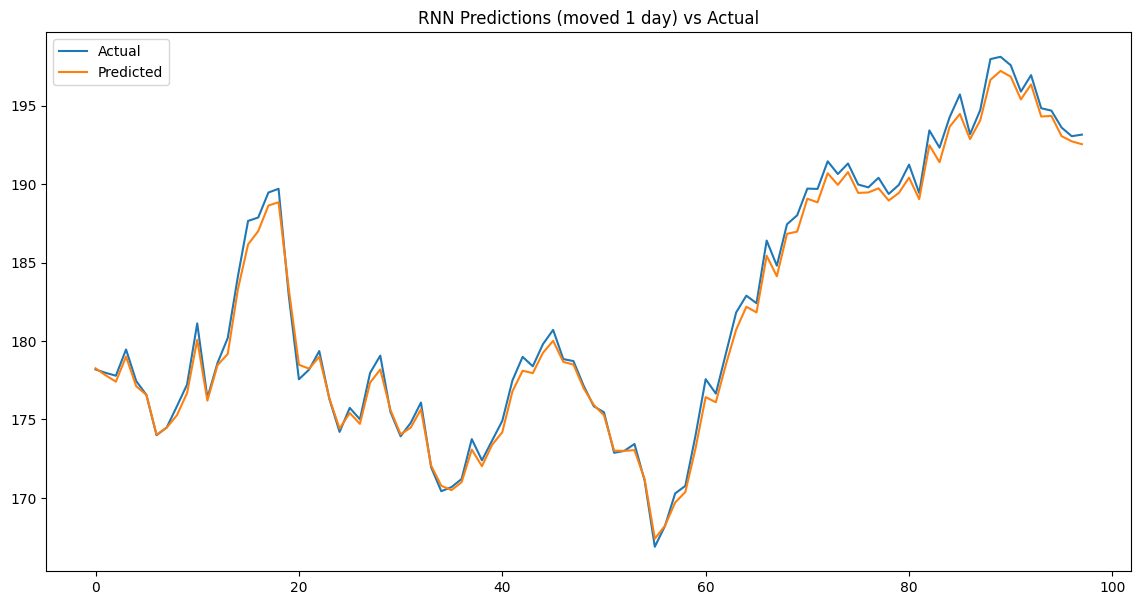

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_new_inverse[-100:-2], label='Actual')
plt.plot(y_pred_new_inverse[-99:-1], label='Predicted')
plt.legend()
plt.title('RNN Predictions (moved 1 day) vs Actual')
plt.show()